# DRD2 transcripts

DRD2S is ENST00000346454.7

DRD2L is ENST00000362072.7

Here, we look at DRD2 gene expression in case/control and in control/schizoNoAP/schizoAP. 

We look at eQTL and directionality.

In [1]:
import re
import os, errno
import functools
import subprocess
import numpy as np
import pandas as pd
from plotnine import *
from pandas_plink import read_plink
from warnings import filterwarnings
from matplotlib.cbook import mplDeprecation

In [2]:
filterwarnings("ignore",category=mplDeprecation)
filterwarnings('ignore', category=UserWarning, module='plotnine.*')
filterwarnings('ignore', category=DeprecationWarning, module='plotnine.*')

In [3]:
config = {
    'biomart_file': '../_h/biomart.csv',
    'caudate_snps': '../_h/drd2_transcripts_pgc2_eqtls.txt',
    'phenotype_file': "/ceph/projects/v3_phase3_paper/inputs/gtex_v8/phenotypes/_m/gtex_v8_sample_data.txt",
    'eqtl_residual_expression_file': '../../../residualized_expression/_m/transcripts_residualized_expression.csv',
    'plink_file_prefix': '/ceph/projects/v3_phase3_paper/inputs/gtex_v8/genotypes_chr11/subset_caudate/_m/gtex_v8_chr11',
    'matrixeqtl_output_file': '../../_m/cis_eqtl_trasncripts.ctxt',
    'gwas_snp_file': '/ceph/projects/v3_phase3_paper/inputs/gtex_v8/genotypes_chr11/subset_caudate/pgc2_map/_m/libd_hg38_pggc2sz_snps.tsv',
}

# Plotting eQTLs

In [4]:
@functools.lru_cache()
def get_biomart_df():
    biomart = pd.read_csv(config['biomart_file'])
    biomart['description'] = biomart['description'].str.replace('\[Source.*$','')
    return biomart


@functools.lru_cache()
def get_eqtl_residual_expression_df():
    eqtl_residual_expression_df = pd.read_csv(config['eqtl_residual_expression_file'], index_col=0).transpose()
    return eqtl_residual_expression_df


@functools.lru_cache()
def get_pheno_df():
    pheno_df = pd.read_csv(config['phenotype_file'], index_col=0)
    return pheno_df


@functools.lru_cache()
def get_eqtl_expression_and_pheno_df():
    return pd.merge(get_pheno_df(), get_eqtl_residual_expression_df(), left_index=True, right_index=True)

In [5]:
def get_gene_symbol(gene_id, biomart=get_biomart_df()):
    ensge = re.sub('\..+$','', gene_id)
    ggg = biomart[biomart['ensembl_gene_id']==ensge]
    if ggg.shape[0]==0:
        return '', ''

    gs = ggg['external_gene_name'].values[0]
    de = ggg['description'].values[0]
    if type(de)!=str:
        de = ''
        
    de = re.sub('\[Source:.*$','',de)
    return gs, de

In [6]:
@functools.lru_cache()
def get_gene_id_df():
    return pd.DataFrame({'gene_id': get_eqtl_residual_expression_df().columns,
                         'ensembl_gene_id': get_eqtl_residual_expression_df().columns.str.replace('\..+$','')})


@functools.lru_cache()
def gene_info_from_symbol(gene_symbol):
    
    gene_id_df = get_gene_id_df()
    biomart=get_biomart_df()
    r = biomart[biomart['external_gene_name']==gene_symbol].merge(gene_id_df, on='ensembl_gene_id', how='left')
    
#      gene_id_dict = get_residual_expression_df().columns.str.replace('\..+$','')
    return r


@functools.lru_cache()
def gene_id_from_symbol(gene_symbol):
    df = gene_info_from_symbol(gene_symbol)
    assert df.shape[0] == 1
    
    return df[['gene_id']].iloc[0].values[0]


@functools.lru_cache()
def get_plink_tuple():
    '''
    Usage: (bim, fam, bed) = get_plink_tuple()
    '''
    return read_plink(config['plink_file_prefix'])


@functools.lru_cache()
def get_eqtl_df():
    return pd.read_csv(config['matrixeqtl_output_file'], sep='\t', header=None, 
                       names=['SNP', 'gene', 'beta', 't-stat', 'p-value', 'FDR'])


@functools.lru_cache()
def get_gwas_snps():
    return pd.read_csv(config['gwas_snp_file'], sep='\t', index_col=0)
 

In [7]:
def get_gwas_snp(snp_id):
    gwas = get_gwas_snps()
    r = gwas[gwas['our_snp_id']==snp_id]
    assert len(r) == 1
    return r


def letter_snp(number, a0, a1):
    '''
    Example:
    letter_snp(0, 'A', 'G') is 'AA'
    letter_snp(1, 'A', 'G') is 'AG'
    letter_snp(2, 'A', 'G') is 'GG'
    
    '''
    if np.isnan(number):
        return np.nan
    
    if len(a0)==1 and len(a1)==1:
        sep = ''
    else:
        sep = ' '
    return sep.join(sorted([a0]*int(number) + [a1]*(2-int(number))))


In [8]:
@functools.lru_cache()
def get_plink_tuple():
    '''
    Usage: (bim, fam, bed) = get_plink_tuple()
    '''
    return read_plink(config['plink_file_prefix'])


@functools.lru_cache()
def get_snp_df(snp_id):
    '''
    Returns a dataframe containing the genotype on snp snp_id.
    The allele count is the same as in the plink files.
    
    Example: 
    get_snp_df('chr11_113501949_C_T_b38').head(2)
    
             	chr11_113501949_C_T_b38_num 	chr11_113501949_C_T_b38_letter 	chr11_113501949_C_T_b38
    GTEX-11WQC 	1 	CT 	1\nCT
    GTEX-14LZ3 	2 	TT 	2\nTT
    '''
    (bim, fam, bed) = get_plink_tuple()
    brain_ids = list(set(get_eqtl_expression_and_pheno_df().index).intersection(set(fam['fid'])))
    snp_info = bim[bim['snp']==snp_id]
    snp_pos = snp_info.iloc[0]['i']
    fam_pos = list(fam.set_index('fid').loc[brain_ids]['i'])
    dfsnp = (pd.DataFrame(bed[[snp_pos]].compute()[:,fam_pos], columns=brain_ids, index=[snp_id + '_num'])
             .transpose().dropna())
    my_letter_snp = functools.partial(letter_snp, a0=snp_info.iloc[0]['a0'], a1=snp_info.iloc[0]['a1'])
    dfsnp[[snp_id + '_num']] = 2 - dfsnp[[snp_id + '_num']].astype('int')
    dfsnp[snp_id + '_letter'] = dfsnp[snp_id + '_num'].apply(my_letter_snp)
    dfsnp[snp_id] = (dfsnp[snp_id + '_num'].astype('str') + '\n' + 
                     dfsnp[snp_id + '_letter'].astype('str')).astype('category')
    return dfsnp


@functools.lru_cache()
def get_gwas_ordered_snp_df(snp_id):
    '''
    Returns a dataframe containing the genotype on snp snp_id.
    The allele count is the number of risk alleles according to GWAS.
    
    Example: 
    get_gwas_ordered_snp_df('rs653953').head(5)
    
            rs653953_num rs653953_letter rs653953
Br5168             2              GG    2\nGG
Br2582             1              AG    1\nAG
Br2378             1              AG    1\nAG
Br5155             0              AA    0\nAA
Br5182             0              AA    0\nAA

    
    '''
    pgc = get_gwas_snps()
    dfsnp = get_snp_df(snp_id).copy()
    gwas_snp = get_gwas_snp(snp_id)
    
    if gwas_snp['pgc2_a1_same_as_our_counted'].iloc[0]:
        if gwas_snp['OR'].iloc[0] > 1:
            pass
        else:
            dfsnp[[snp_id + '_num']] = 2 - dfsnp[[snp_id + '_num']]
    else:
        if gwas_snp['OR'].iloc[0] > 1:
            dfsnp[[snp_id + '_num']] = 2 - dfsnp[[snp_id + '_num']]
        else:
            pass
        
    dfsnp[snp_id] = (dfsnp[snp_id + '_num'].astype('str') + '\n' + 
                     dfsnp[snp_id + '_letter'].astype('str')).astype('category')
    return dfsnp


@functools.lru_cache()
def get_risk_allele(snp_id):
    gwas_snp = get_gwas_snp(snp_id)
    if gwas_snp['OR'].iloc[0] > 1:
        ra = gwas_snp['A1'].iloc[0]
    else:
        ra = gwas_snp['A2'].iloc[0]
    return ra


@functools.lru_cache()
def get_gwas_eqtl_merge():
    gwas = get_gwas_snps()
    eqtl = get_eqtl_df()
    return eqtl.merge(gwas, left_on='SNP', right_on='our_snp_id', suffixes=['_eqtl', '_gwas'])
    

In [9]:
def mkdir_p(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
            

def save_plot(p, fn):
    for ext in ['png', 'pdf', 'svg']:
        p.save(fn + '.' + ext)


def gwas_annotation(snp_id):
    return 'SNP GWAS pvalue: %.1e' % get_gwas_snp(snp_id).iloc[0]['P']


def eqtl_gwas_annotation(snp_id, gene_id):
    eqtl_df = get_gwas_eqtl_merge()
    r = eqtl_df[(eqtl_df['SNP_eqtl']==snp_id) & (eqtl_df['gene']==gene_id)]
    assert len(r)==1
    matrix_sign = -1 # based on /ceph/users/apua/projects/chr11_gtex/_m
    sign = [-1,1][int(r.iloc[0]['pgc2_a1_same_as_our_counted'])] *\
        [-1,1][int(r.iloc[0]['OR'] > 1.0)] * matrix_sign
    return 'eQTL t-stat: %.2f  FDR: %.1e' % (sign * r.iloc[0]['t-stat'], r.iloc[0]['FDR'])


def risk_allele_annotation(snp_id):
    return 'SCZD risk allele: %s' % get_risk_allele(snp_id)


def gwas_annotated_eqtl_plot(snp_id, gene_id, title_prefix = []):
    p = simple_gwas_ordered_snp_expression_plot(snp_id, gene_id)
    title ="\n".join(title_prefix + [gwas_annotation(snp_id),
                     risk_allele_annotation(snp_id),
                     eqtl_gwas_annotation(snp_id, gene_id)
                     ])
    p += ggtitle(title) + ylab('Residualized Expression') 
    return p

In [10]:
@functools.lru_cache()
def get_gwas_ordered_snp_df(snp_id):
    '''
    Returns a dataframe containing the genotype on snp snp_id.
    The allele count is the number of risk alleles according to GWAS.
    
    Example: 
    get_gwas_ordered_snp_df('chr11_113501949_C_T_b38').head(2)
    
            chr11_113501949_C_T_b38_num 	chr11_113501949_C_T_b38_letter 	chr11_113501949_C_T_b38
    GTEX-11WQC 	1 	CT 	1\nCT
    GTEX-14LZ3 	2 	TT 	2\nTT    
    '''
    pgc = get_gwas_snps()
    dfsnp = get_snp_df(snp_id).copy()
    gwas_snp = get_gwas_snp(snp_id)
    if gwas_snp['pgc2_a1_same_as_our_counted'].iloc[0]:
        if gwas_snp['OR'].iloc[0] > 1:
            pass
        else:
            dfsnp[[snp_id + '_num']] = 2 - dfsnp[[snp_id + '_num']]
    else:
        if gwas_snp['OR'].iloc[0] > 1:
            dfsnp[[snp_id + '_num']] = 2 - dfsnp[[snp_id + '_num']]
        else:
            pass
    dfsnp[snp_id] = (dfsnp[snp_id + '_num'].astype('str') + '\n' + 
                     dfsnp[snp_id + '_letter'].astype('str')).astype('category')
    return dfsnp


@functools.lru_cache()
def get_pheno_df():
    pheno_df = pd.read_csv(config['phenotype_file'], index_col=3, sep='\t')
    return pheno_df.iloc[:, 0:15]


@functools.lru_cache()
def get_eqtl_expression_and_pheno_df():
    return pd.merge(get_pheno_df(), get_eqtl_residual_expression_df(), left_index=True, right_index=True)


@functools.lru_cache()
def get_risk_allele(snp_id):
    gwas_snp = get_gwas_snp(snp_id)
    if gwas_snp['OR'].iloc[0] > 1:
        ra = gwas_snp['A1'].iloc[0]
    else:
        ra = gwas_snp['A2'].iloc[0]
    return ra



In [11]:
def get_snp_gene_pheno_df(snp_id, gene_id, snp_df_func):
    pheno_columns = list(get_pheno_df().columns)
    expr_df = get_eqtl_expression_and_pheno_df()[pheno_columns + [gene_id]]
    snp_df =  snp_df_func(snp_id)
    return expr_df.merge(snp_df, left_index=True, right_index=True)
    

def simple_snp_expression_plot_impl(snp_id, gene_id, snp_df_func):
    df = get_snp_gene_pheno_df(snp_id, gene_id, snp_df_func)
    y0 = df[gene_id].quantile(.03) - 0.26
    y1 = df[gene_id].quantile(.97) + 0.26
    p = ggplot(df, aes(x=snp_id, y=gene_id)) \
    + theme_matplotlib()\
    + geom_boxplot(fill='red', alpha=0.4, outlier_alpha=0)\
    + geom_jitter(stroke=0, color='black', alpha=0.7, width=0.25)\
    + ylim(y0, y1)\
    + theme(axis_text=element_text(size=16), 
            axis_title=element_text(size=16, face='bold'), 
            plot_title=element_text(size=14))
    return p


def simple_gwas_ordered_snp_expression_plot(snp_id, gene_id):
    return simple_snp_expression_plot_impl(snp_id, gene_id, get_gwas_ordered_snp_df)


# DRD2

In [12]:
phase3_snps = pd.read_csv(config['caudate_snps'], sep='\t')
phase3_snps[['SNP_eqtl', 'gene', 'SNP_gwas', 'hg38pos', 'rsid']].head()

,SNP_eqtl,gene,SNP_gwas,hg38pos,rsid
0,rs17601612:113317745:G:C,ENST00000346454.7,rs17601612:113317745:G:C,113447023,rs17601612
1,rs4337071:113334100:C:T,ENST00000346454.7,rs4337071:113334100:C:T,113463378,rs4337071


In [13]:
gwas_eqtl_df = get_gwas_eqtl_merge()
gwas_eqtl_df[['SNP_eqtl', 'gene', 'SNP_gwas', 'hg38pos', 'rsid']].head()

,SNP_eqtl,gene,SNP_gwas,hg38pos,rsid
0,chr11_113358943_T_C_b38,ENST00000362072.7,rs7939992:113229665:T:C,113358943,rs7939992
1,chr11_113358943_T_C_b38,ENST00000544518.5,rs7939992:113229665:T:C,113358943,rs7939992
2,chr11_113358943_T_C_b38,ENST00000346454.7,rs7939992:113229665:T:C,113358943,rs7939992
3,chr11_113353682_A_G_b38,ENST00000544518.5,rs11214583:113224404:A:G,113353682,rs11214583
4,chr11_113353682_A_G_b38,ENST00000362072.7,rs11214583:113224404:A:G,113353682,rs11214583


In [14]:
snps = pd.merge(phase3_snps[['SNP_eqtl', 'gene', 'SNP_gwas', 'hg38pos', 'rsid']], 
                gwas_eqtl_df[['SNP_eqtl', 'gene', 'SNP_gwas', 'hg38pos', 'rsid']], 
                on=['gene', 'hg38pos', 'SNP_gwas', 'rsid'], suffixes=['_phase3', '_gtex'])
snps

,SNP_eqtl_phase3,gene,SNP_gwas,hg38pos,rsid,SNP_eqtl_gtex
0,rs17601612:113317745:G:C,ENST00000346454.7,rs17601612:113317745:G:C,113447023,rs17601612,chr11_113447023_G_C_b38
1,rs4337071:113334100:C:T,ENST00000346454.7,rs4337071:113334100:C:T,113463378,rs4337071,chr11_113463378_C_T_b38


Mapping files: 100%|██████████| 3/3 [00:06<00:00,  2.22s/it]


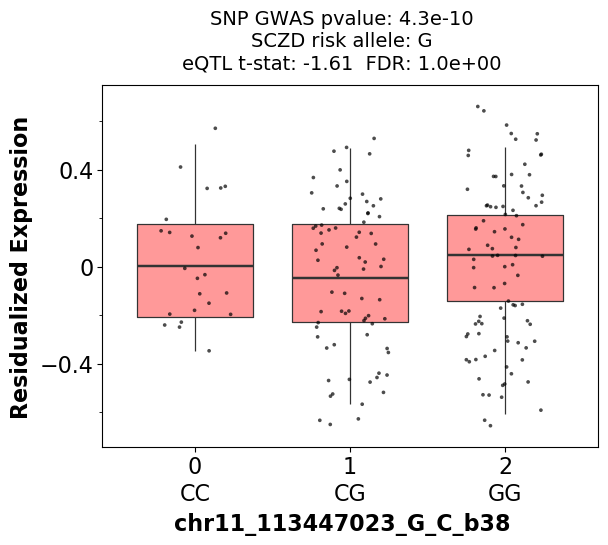

<ggplot: (8759890607677)>

In [15]:
p = gwas_annotated_eqtl_plot('chr11_113447023_G_C_b38', 'ENST00000346454.7')
p

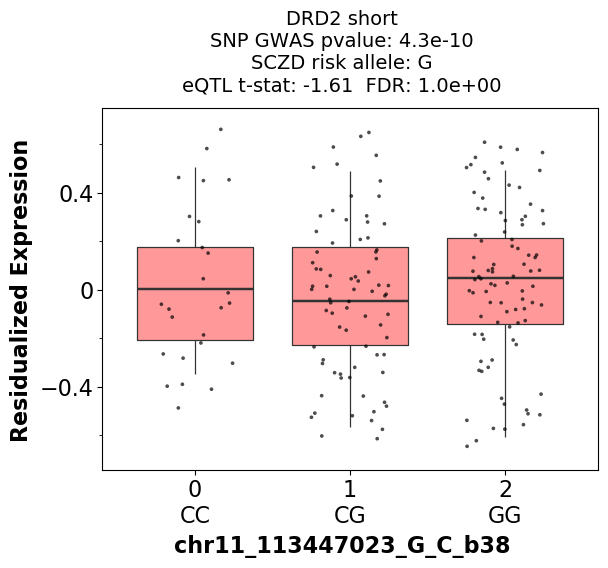

<ggplot: (8759890564711)>


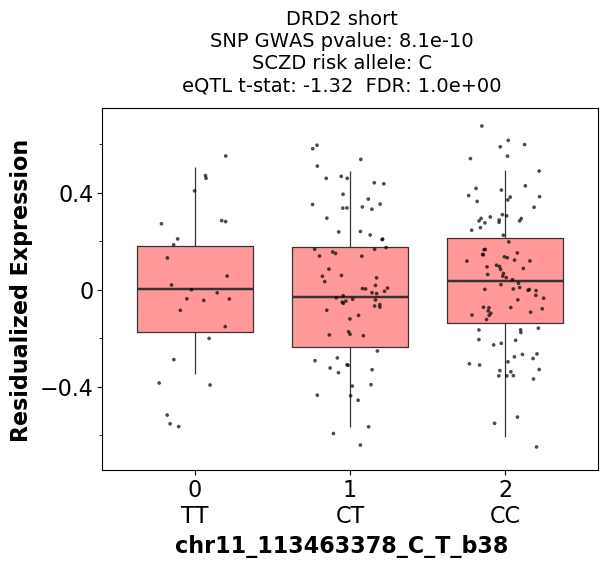

<ggplot: (8759890553995)>


In [16]:
feature = 'transcripts'
mkdir_p(feature)
for snp_id in snps.SNP_eqtl_gtex:
    p = gwas_annotated_eqtl_plot(snp_id, 'ENST00000346454.7', ['DRD2 short'])
    save_plot(p, "%s/drd2_short_eqtl_%s" % (feature, snp_id))
    print(p)